# EXCERCISE: Model Building and Scoring (XGBoost)

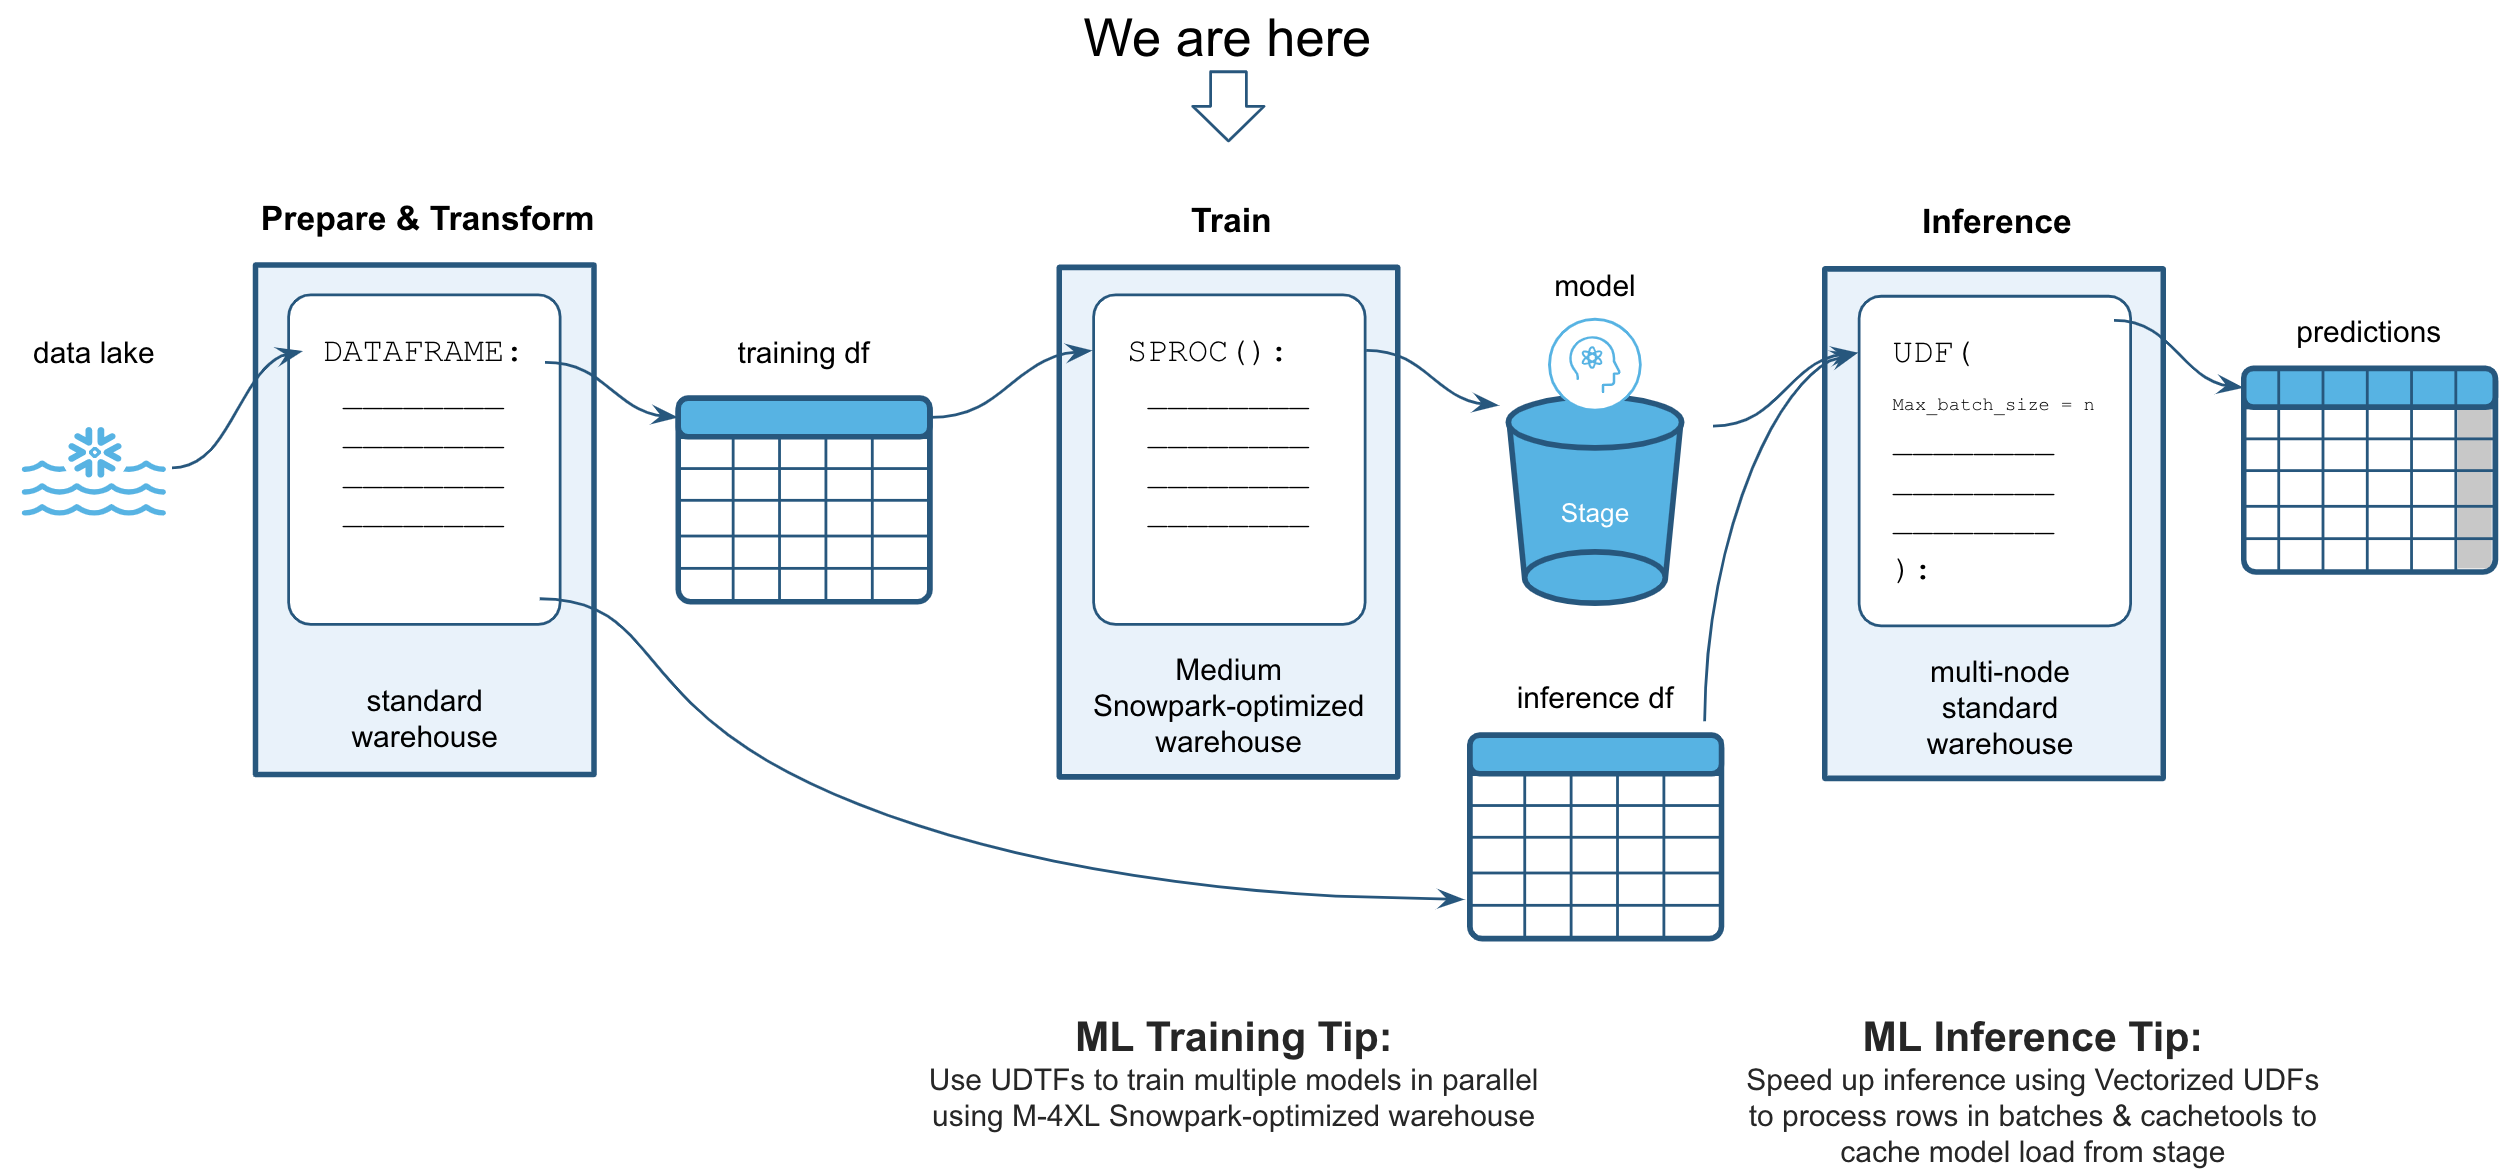

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
import preprocessing

import getpass
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create Snowpark Session

In [2]:
accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

········


In [3]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

········


In [4]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

········


In [5]:
connection_parameters = {
    "account": 'ujscxjb-gh31861',
    "user": 'syedhossain3',
    "password": 'Samayra2006',
    "role": "ACCOUNTADMIN",
    "database": "HOL_DB",
    "schema": "PUBLIC",
    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

# Model Building

In [6]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

# EXERCISE: Define your Stored Procedure to train an XGBoost Model

In [7]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake

def sproc_train_xgboost_model(session: Session, 
                              training_table: str, 
                              feature_cols: list,
                              target_col: str,
                              model_name: str) -> T.Variant:
    
    # WORKFLOW
    # 1: Load data into Pandas DataFrame
    local_training_data = session.table(training_table).to_pandas()
    # 2: Define features and Label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]
    # 3: Train the model
    import xgboost as xgb
    xb = xgb.XGBClassifier(random_state=123) 
    xb.fit(X,y)
    # 4: (Optional) Return feature importance
    feat_importance = pd.DataFrame(xb.feature_importances_,feature_cols,columns=['FeatImportance']).to_dict()
    # 5: Save the model and upload to Snowflake Stage
    from joblib import dump
    dump(xb, '/tmp/'+model_name)
    session.file.put('/tmp/'+model_name, '@ML_MODELS', auto_compress=False, overwrite=True)
    return feat_importance


# EXERCISE: Register your Stored Procedure to train an XGBoost Model

In [8]:
# Registering the function as a Stored Procedure
sproc_xgboost_model = session.sproc.register(func=sproc_train_xgboost_model, 
                                             name='sproc_train_xgboost_model', 
                                             is_permanent=True, 
                                             replace=True, 
                                             stage_location='@ML_MODELS', 
                                             packages=['snowflake-snowpark-python','scikit-learn','xgboost','joblib'])

# EXERCISE: Run your Stored Procedure to train an XGBoost Model

In [9]:
training_table = 'CREDIT_RISK_PREPARED_BALANCED_TRAIN' # YOUR TRAINING TABLE  #
feature_cols   = train_sdf.columns# YOUR FEATURE COLUMNS #
feature_cols.remove('TARGET')
target_col     = 'TARGET'# YOUR TARGET COLUMN   #
model_name     = 'xgboost_model.sav' # YOUR MODEL NAME      #

feature_importance = sproc_xgboost_model(training_table, 
                             feature_cols, 
                             target_col,
                             model_name, 
                             session=session)

feature_importance = pd.DataFrame(eval(feature_importance))

In [10]:
# The model is now stored in a Snowflake stage
pd.DataFrame(session.sql('LIST @ML_MODELS').collect())

,name,size,md5,last_modified
0,ml_models/logistic_reg_model.sav,2976,a15925bd248434d99af769b4f24c9716,"Sun, 25 Dec 2022 01:49:14 GMT"
1,ml_models/xgboost_model.sav,526000,43f0cabae2eeb2a3d3dc23425d2be3cd,"Mon, 26 Dec 2022 01:29:05 GMT"


<AxesSubplot: >

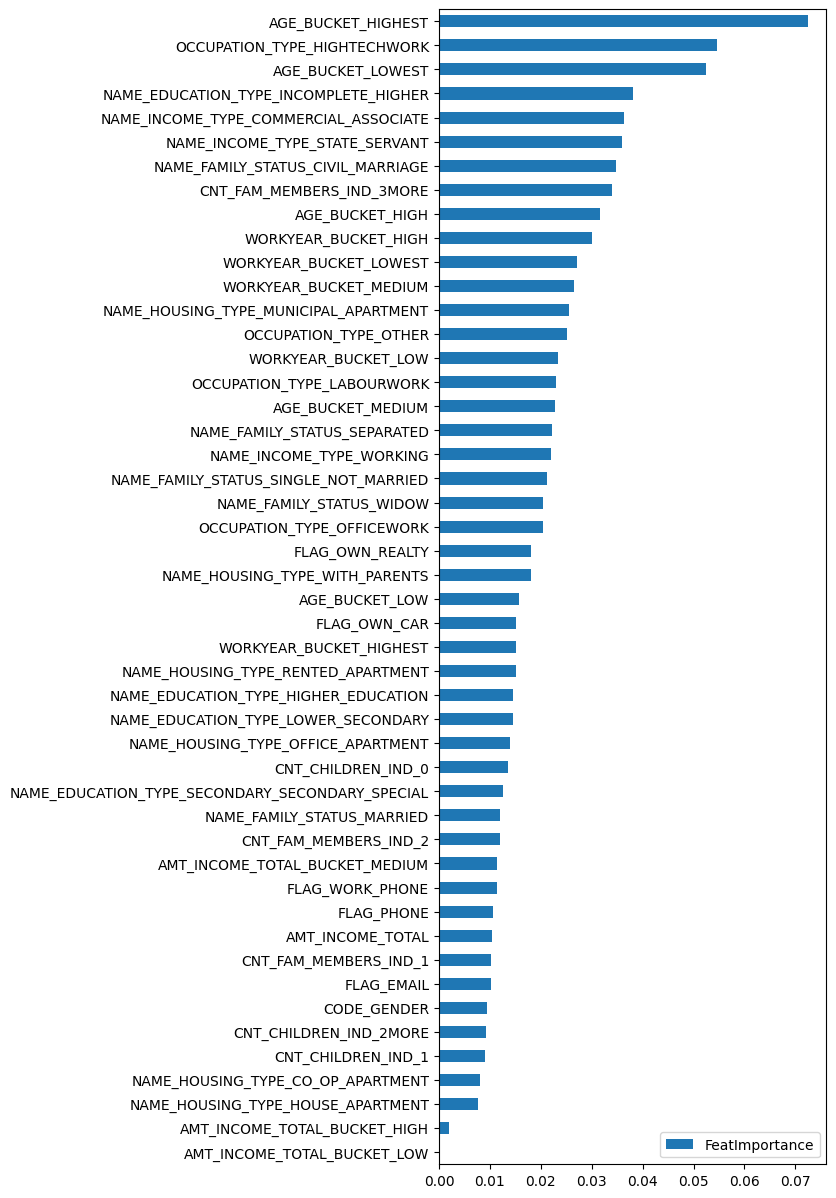

In [11]:
feature_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))

# Model Scoring

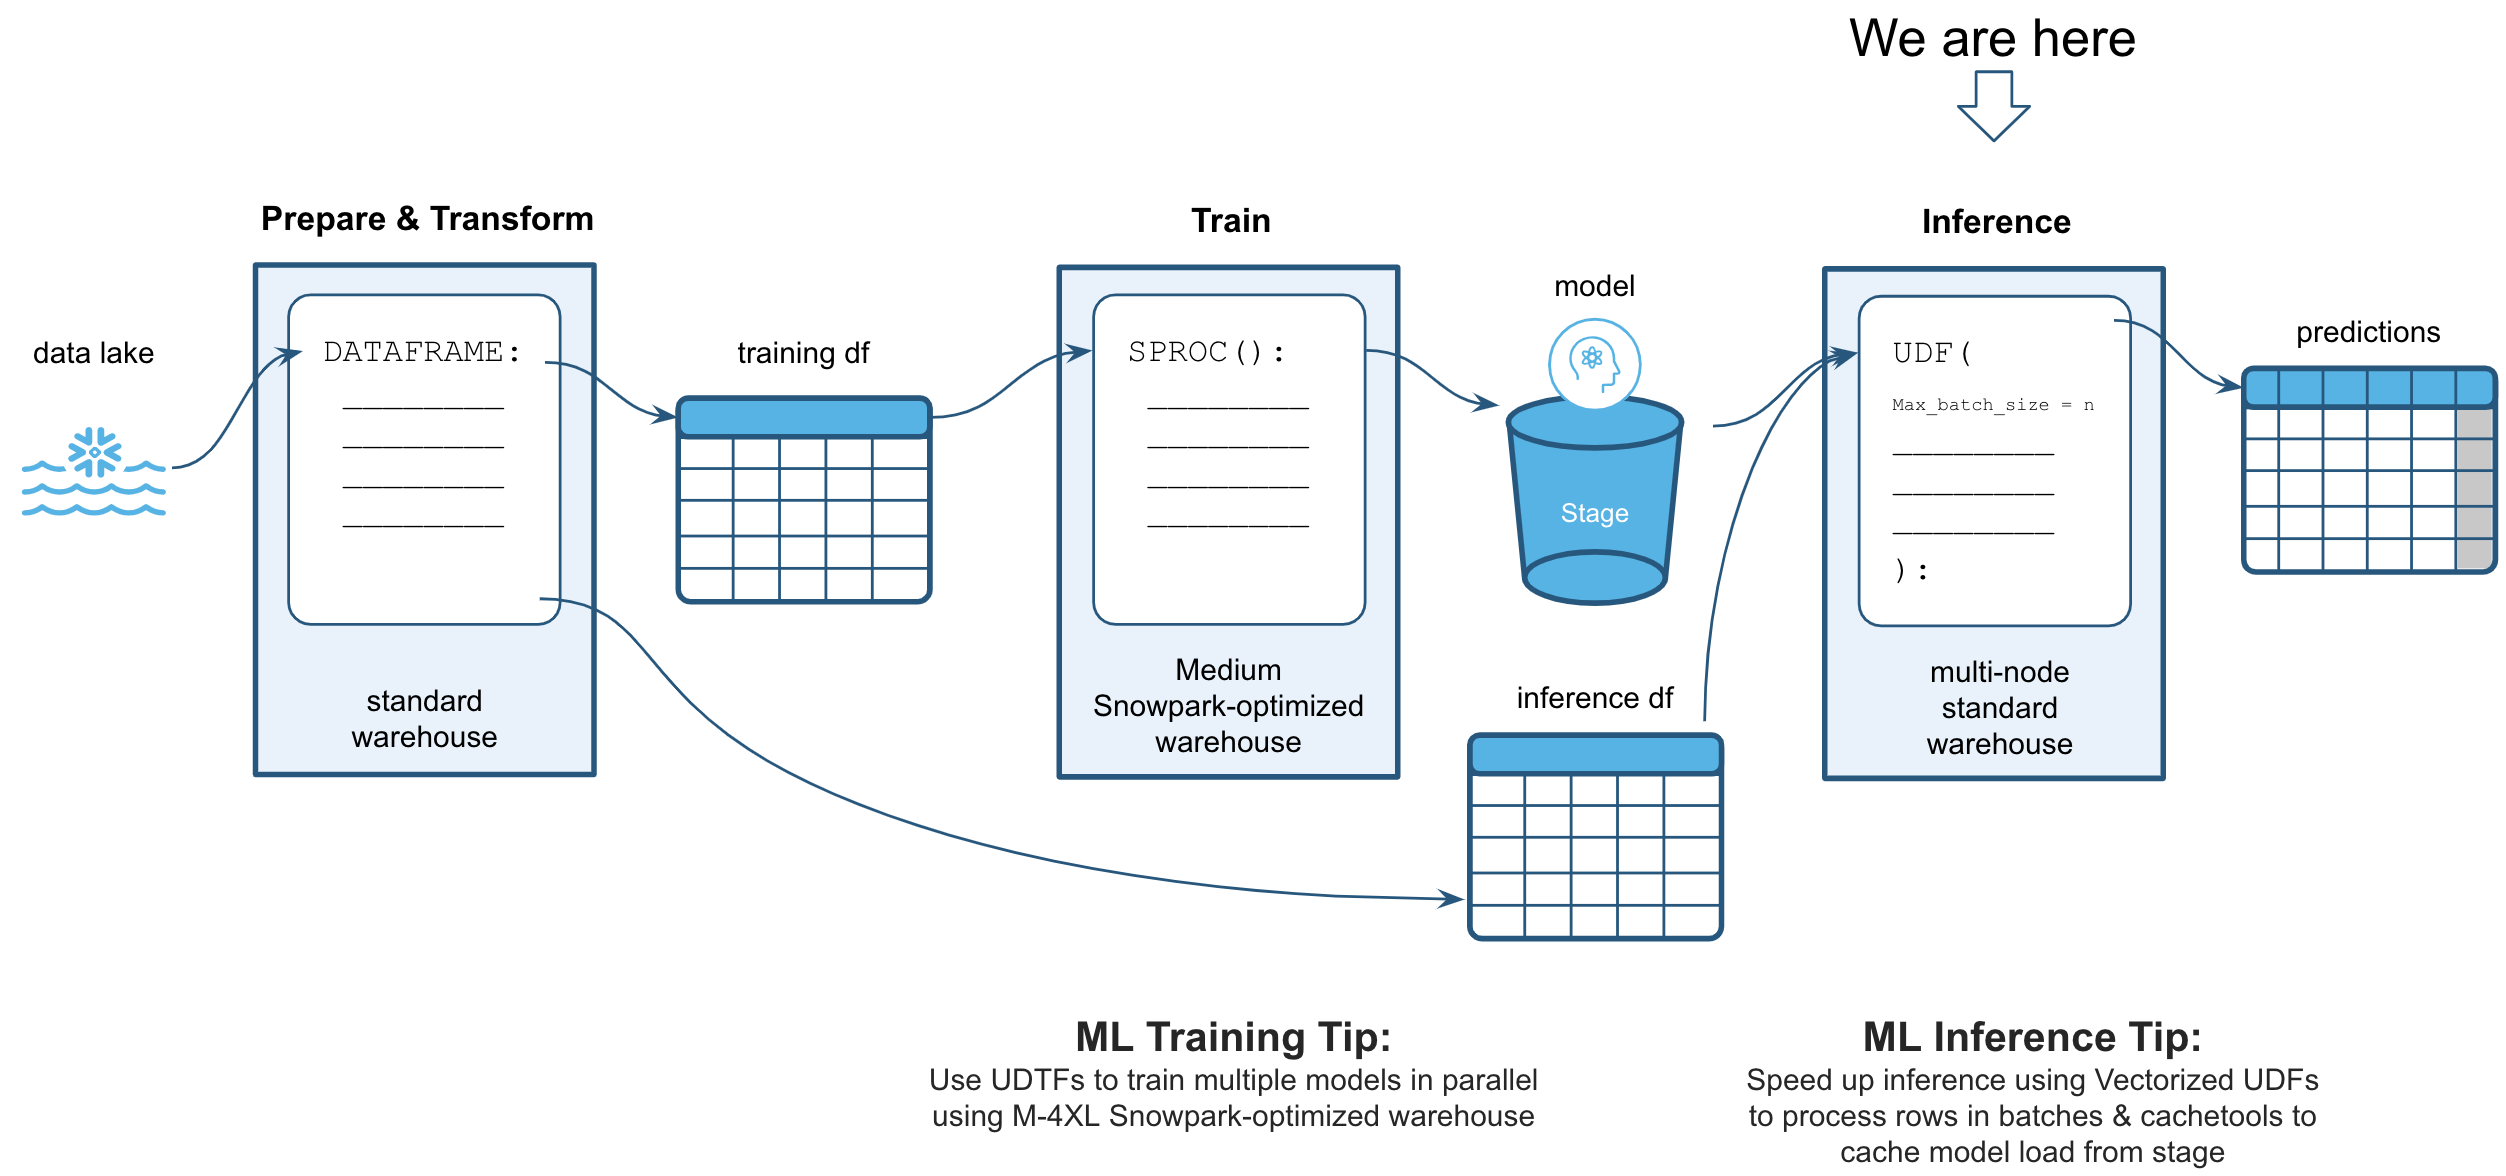

# EXERCISE: Define your UDF to Score an XGBoost Model

In [12]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_logistic_xgboost_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'xgboost_model.sav'
    model = load_model(import_dir+model_name)
    scored_data = pd.Series(model.predict(df))
    return scored_data
    # WORKFLOW
    # 1: Load the model from the import directory using load_model()
     
    # 2: Score the incoming DataFrame using model.predict()
    # 3: Return the scores as a variable scored_data
    
    ##################################
    ## Insert your code after this  ##
    ##################################

    ##################################
    ## Insert your code before this ##
    ##################################
    return scored_data

# EXERCISE: Register your UDF to Score an XGBoost Model

In [15]:
# Register UDF
udf_score_logistic_xgboost_model_vec_cached = session.udf.register(func=udf_score_logistic_xgboost_model_vec_cached, 
                                                                   name='udf_score_xgboost_model', 
                                                                   stage_location='@ML_MODELS',
                                                                   input_types=[T.FloatType()]*len(feature_cols),
                                                                   return_type = T.FloatType(),
                                                                   replace=True, 
                                                                   is_permanent=True, 
                                                                   imports=['@ML_MODELS/xgboost_model.sav'],
                                                                   packages=['scikit-learn==1.1.1','pandas','joblib','xgboost','cachetools'], 
                                                                   session=session)

# EXERCISE: Run your UDF to Score an XGBoost Model

In [17]:
%%time
# Scoring test data with scalar UDF but caching the model
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_xgboost_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED', mode='overwrite')

CPU times: user 30.9 ms, sys: 5.39 ms, total: 36.3 ms
Wall time: 3.43 s


In [18]:
scored_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED')

In [19]:
# Obtaining a simple confusion matrix
scored_sdf.group_by(['TARGET','PREDICTION']).count().to_pandas()

,TARGET,PREDICTION,COUNT
0,0,0.0,5934
1,1,0.0,53
2,1,1.0,5961
3,0,1.0,80


In [20]:
# Define functions to calculate metrics
def accuracy_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    accuracy = (tp+tn) / (tp+tn+fn+fp)
    return accuracy

def precision_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    precision = tp / (tp+fp)
    return precision

def recall_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    recall = tp / (tp+fn)
    return recall

def f1_score(df, y_true, y_pred):
    precision = precision_score(df, y_true=y_true, y_pred=y_pred)
    recall = recall_score(df, y_true=y_true, y_pred=y_pred)
    f1_score = (2*precision*recall) / (precision+recall)
    return f1_score

def confusion_matrix(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    conf_matrix = [[tn, fp], [fn, tp]]
    return conf_matrix

Accury: 0.9889424675756568
Precision: 0.9867571594106936
Recall: 0.99118722979714
F1: 0.9889672335130653


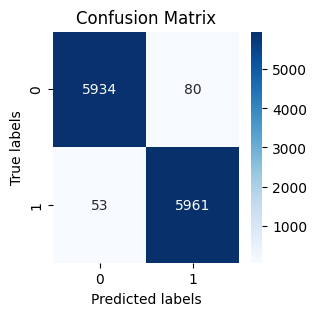

In [21]:
# Visualizing Confusion Matrix
cf_matrix = confusion_matrix(scored_sdf, y_true='TARGET', y_pred='PREDICTION')
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Calculating Statistics
print('Accury:', accuracy_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))
print('Precision:', precision_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))
print('Recall:', recall_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))
print('F1:', f1_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))